In [1]:
#Loan Default Prediction
#Author: Jessie Justice
#Date: 02/17/2025

In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import sklearn as sk
import sys
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [3]:
#Ingest Data
path = kagglehub.dataset_download("nikhil1e9/loan-default", force_download = True)

Loan_Default = pd.read_csv(path + "\loan_default.csv")

100%|█████████████████████████████████████████████████████████████████████████████| 7.86M/7.86M [00:01<00:00, 7.57MB/s]

Extracting files...


In [4]:
#Exploratory Data Analysis/Data Validation/Sanity Checks

#get summary statistics
Loan_Default.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [5]:
#check for NA values
Loan_Default.isna().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [6]:
#check for duplicate values
Loan_Default.duplicated().sum()

0

In [7]:
#Data Wrangling and Visualization

#get list of numeric feature/variable names
Num_Features = list(Loan_Default.select_dtypes(include = np.number))

#get list of categorical variables, exclude LoanID by index
Cat_Features = list(Loan_Default.select_dtypes(include = object))[1:8]

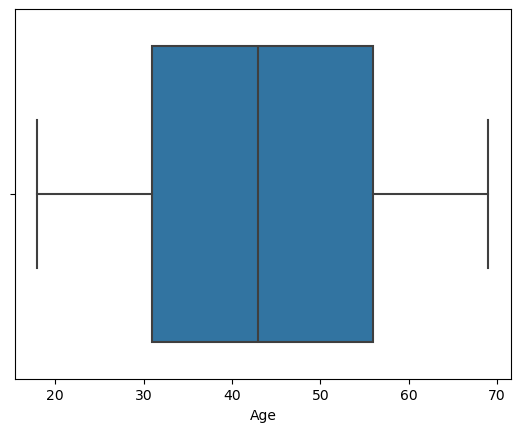

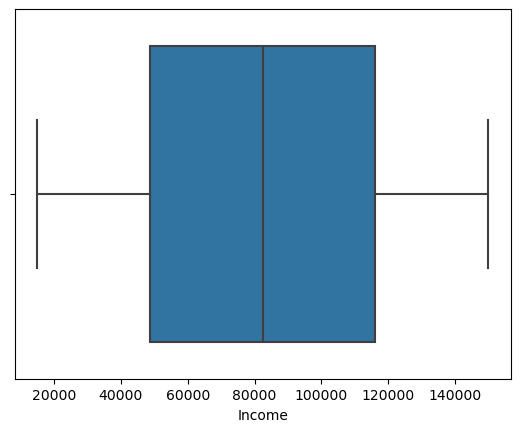

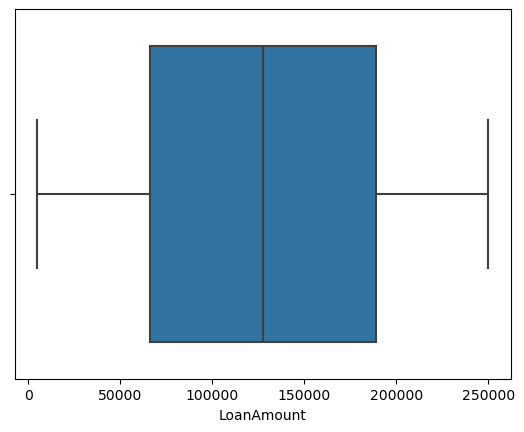

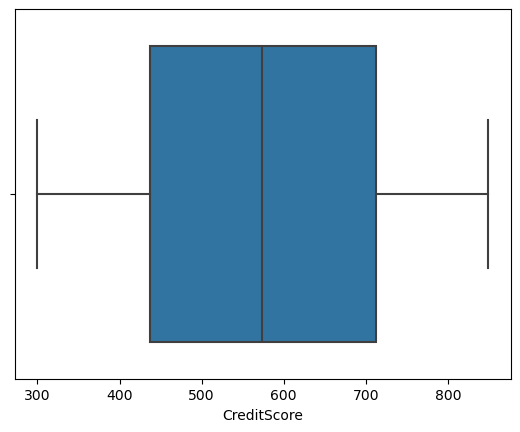

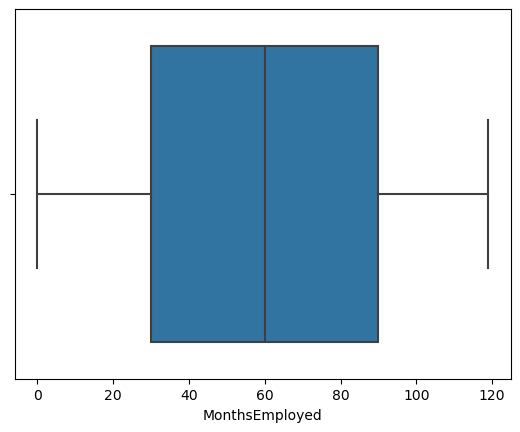

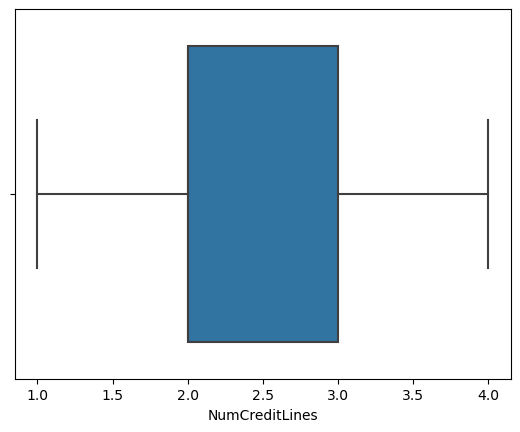

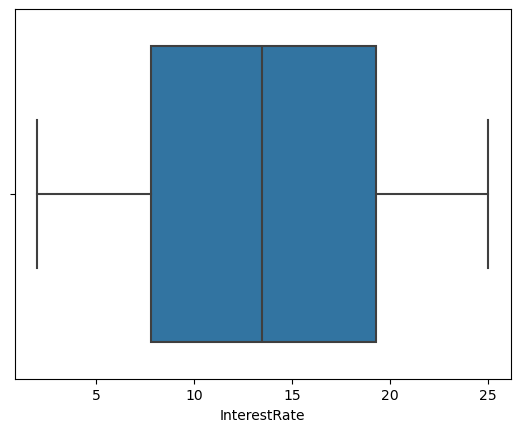

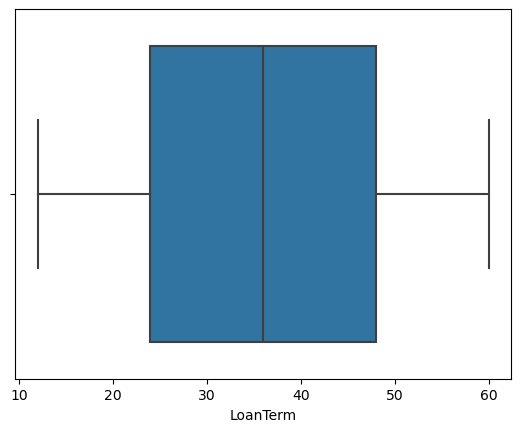

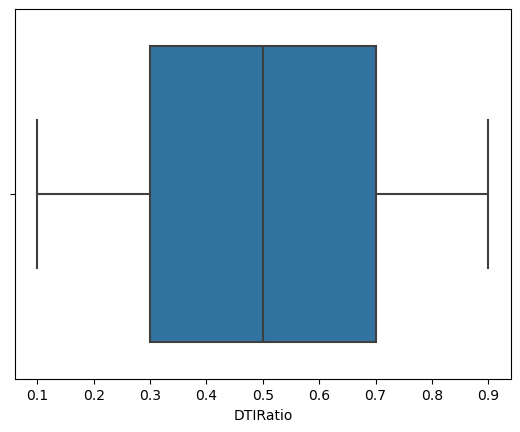

[None, None, None, None, None, None, None, None, None]

In [8]:
#iterate over list of numeric features to get boxplots
def plot_and_show (df,var):
        
    sns.boxplot(x = df[var])

    plt.show()

[plot_and_show(Loan_Default, i) for i in Num_Features[0:9]]

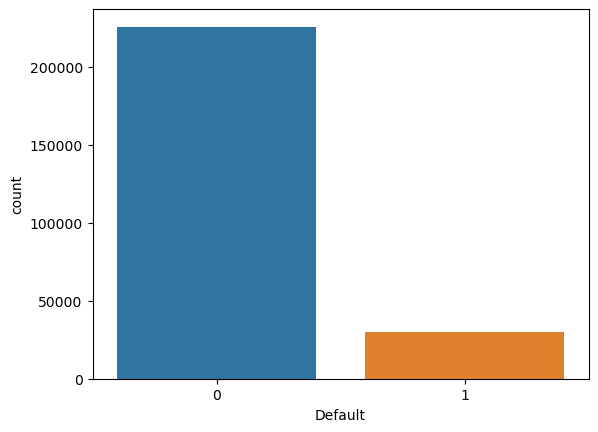

In [9]:
#encode categorical variables
Loan_Default[Cat_Features] = Loan_Default[Cat_Features].apply(LabelEncoder().fit_transform)

#check for class imbalance in default
sns.countplot(x = Loan_Default['Default'])

plt.show()

In [10]:
#generate correlation matrix
Loan_Default[(Num_Features + Cat_Features)].corr().style.highlight_max(color = 'orange', axis = 1, subset = 'Default')

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
Age,1.000000,-0.001244,-0.002213,-0.000548,-0.000341,-0.000890,-0.001127,0.000263,-0.004689,-0.167783,-0.000882,0.000787,-0.002187,0.000035,0.000710,0.002264,-0.002918
Income,-0.001244,1.000000,-0.000865,-0.001430,0.002675,-0.002016,-0.002303,-0.000998,0.000205,-0.099119,-0.000965,-0.005146,0.000637,-0.000945,-0.001570,-0.002092,-0.003524
LoanAmount,-0.002213,-0.000865,1.000000,0.001261,0.002817,0.000794,-0.002291,0.002538,0.001122,0.086659,0.002551,0.003060,-0.000771,-0.000801,0.000139,0.000057,-0.001848
CreditScore,-0.000548,-0.001430,0.001261,1.000000,0.000613,0.000016,0.000436,0.001130,-0.001039,-0.034166,0.000214,0.003503,-0.003218,0.001728,-0.003018,0.000596,-0.002755
MonthsEmployed,-0.000341,0.002675,0.002817,0.000613,1.000000,0.001267,0.000096,-0.001166,0.001765,-0.097374,-0.001304,0.000564,-0.000095,0.000210,0.001450,-0.002579,0.001045
NumCreditLines,-0.000890,-0.002016,0.000794,0.000016,0.001267,1.000000,-0.000297,-0.000226,-0.000586,0.028330,0.002691,0.000219,-0.000664,-0.001744,-0.001895,0.000340,0.002105
InterestRate,-0.001127,-0.002303,-0.002291,0.000436,0.000096,-0.000297,1.000000,0.000892,0.000575,0.131273,0.002879,0.000525,-0.005079,-0.000424,-0.000243,0.001472,-0.003991
LoanTerm,0.000263,-0.000998,0.002538,0.001130,-0.001166,-0.000226,0.000892,1.000000,0.002273,0.000545,-0.002999,0.000779,-0.001042,0.001775,0.002417,0.002856,-0.001166
DTIRatio,-0.004689,0.000205,0.001122,-0.001039,0.001765,-0.000586,0.000575,0.002273,1.000000,0.019236,0.001789,-0.000578,0.004492,0.000231,0.001492,-0.003819,0.000373
Default,-0.167783,-0.099119,0.086659,-0.034166,-0.097374,0.028330,0.131273,0.000545,0.019236,1.000000,-0.022835,0.041010,-0.007902,-0.022856,-0.034678,-0.010096,-0.039109


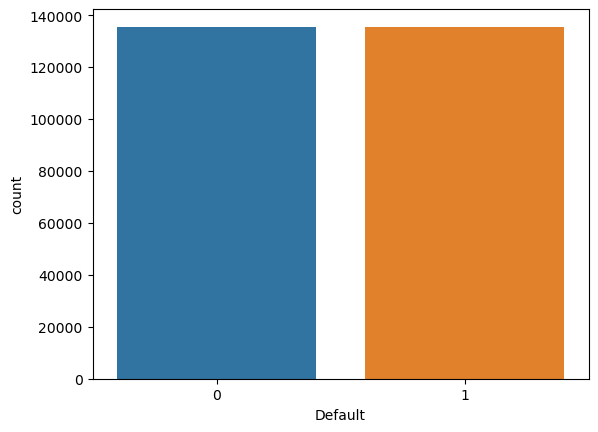

In [11]:
#Modeling and Prediction

#Test-Train Split
X = Loan_Default[Num_Features + Cat_Features].drop('Default', axis  = 1)

y = Loan_Default['Default']

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X,y, test_size=0.4, random_state=57)

#apply SMOTE to balance default classes
smote = SMOTE(random_state=57)

X_train, y_train = smote.fit_resample(X_train, y_train)

#check for class balance visually
sns.countplot(x = y_train)

plt.show()

In [12]:
#Write function to convert string to class
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

#create empty list to append dataframes with model metrics
metrics = []

#write function to fit and score model
def model_fit_and_metrics (classifier):
    
    model = str_to_class(classifier)()

    model_fit = model.fit(X_train, y_train)

    model_pred = model.predict(X_test)

    output_df = pd.DataFrame({'Metric': ['Accuracy','Precision','Recall','F1 Score'], 
                             str(classifier) : [accuracy_score(y_test, model_pred), precision_score(y_test, model_pred),recall_score(y_test, model_pred), f1_score(y_test, model_pred)]})
    
    metrics.append(output_df)    


#list of classifiers
Classifiers = ['LogisticRegression','RandomForestClassifier']

#Iterate over list of classifiers
[model_fit_and_metrics(i) for i in Classifiers]

#merge dataframes in metrics list to create output table
Output_Table = reduce(lambda x,y: pd.merge(x,y, on = 'Metric'), metrics)

print(Output_Table)

      Metric  LogisticRegression  RandomForestClassifier
0   Accuracy            0.640010                0.829996
1  Precision            0.178793                0.252126
2     Recall            0.574321                0.227212
3   F1 Score            0.272693                0.239022
